<a href="https://colab.research.google.com/github/shenghaoc/ee5907-ca2/blob/main/gmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from PIL import Image
from pathlib import Path


In [2]:
# CONSTANTS
NUM_SUBJECTS = 68
NUM_CHOSEN = 25
NUM_IMAGES_PER_SUBJECT = 170

TRAIN_RATIO = 0.7
NUM_IMAGES = NUM_CHOSEN * NUM_IMAGES_PER_SUBJECT
NUM_TRAIN_IMAGES_PER_SUBJECT = np.int_(np.around(TRAIN_RATIO * NUM_IMAGES_PER_SUBJECT))
NUM_TRAIN_IMAGES = NUM_CHOSEN * NUM_TRAIN_IMAGES_PER_SUBJECT
NUM_TEST_IMAGES = NUM_IMAGES - NUM_TRAIN_IMAGES

NUM_SELFIES = 10
NUM_TRAIN_SELFIES = np.int_(np.around(TRAIN_RATIO * NUM_SELFIES))
NUM_TEST_SELFIES = NUM_SELFIES - NUM_TRAIN_SELFIES
SELFIE_LABEL = NUM_SUBJECTS + 1

NUM_TOTAL_TRAIN_IMAGES = NUM_TRAIN_IMAGES + NUM_TRAIN_SELFIES
NUM_TOTAL_TEST_IMAGES = NUM_TEST_IMAGES + NUM_TEST_SELFIES

SEED1 = 2021
SEED2 = 2022

WIDTH = 32
HEIGHT = 32
NUM_PIXELS = WIDTH * HEIGHT


In [3]:
# Ensure that the directory to store figures is created
figures_directory = Path("report") / "figures"
figures_directory.mkdir(exist_ok=True)


In [4]:
# Must start from 1 to accommodate folder naming scheme
# Choose NUM_CHOSEN elements from NUM_SUBJECTS integers without replacement
chosen = np.random.default_rng(SEED1).choice(
    np.arange(1, NUM_SUBJECTS + 1), NUM_CHOSEN, replace=False
)


In [5]:
# Load images from disk
# Use lists for manual looping without use of numpy functions
images = []
labels = []

# Assume PIE is in pwd
directory = Path("PIE")
for i in chosen:
    # Do not flatten yet, need to split train and test for each subject
    subject_images = []
    subject_labels = []
    subdirectory = directory / str(i)
    # Order is arbitrary for glob, but better to shuffle anyway
    files = list(subdirectory.glob("*.jpg"))
    np.random.default_rng(SEED2).shuffle(files)
    for filename in files:
        # PIL is slower but OpenCV is unnecessary
        im = Image.open(filename)
        subject_images.append(np.array(im))
        subject_labels.append(i)  # Use number in PIE for label
    images.append(subject_images)
    labels.append(subject_labels)


In [6]:
# Slightly altered code for selfies
selfie_images = []
selfie_labels = []

directory = Path("resized")
# Assume selfies have been resized and folder is in pwd
for filename in directory.glob("*.jpg"):
    im = Image.open(filename)
    selfie_images.append(np.array(im))
    selfie_labels.append(SELFIE_LABEL)  # add 1 to max PIE number to avoid clashes


In [7]:
# Further processing without disk access
# Train-test split
images_train, images_test = np.split(
    np.array(images), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1
)
labels_train, labels_test = np.split(
    np.array(labels), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1
)

selfie_images_train, selfie_images_test = np.split(
    np.array(selfie_images), [NUM_TRAIN_SELFIES]
)
selfie_labels_train, selfie_labels_test = np.split(
    np.array(selfie_labels), [NUM_TRAIN_SELFIES]
)


In [8]:
# Flatterning
images_train = images_train.reshape(NUM_TRAIN_IMAGES, NUM_PIXELS)
selfie_images_train = selfie_images_train.reshape(NUM_TRAIN_SELFIES, NUM_PIXELS)
images_test = images_test.reshape(NUM_TEST_IMAGES, NUM_PIXELS)
selfie_images_test = selfie_images_test.reshape(NUM_TEST_SELFIES, NUM_PIXELS)

labels_train = labels_train.reshape(NUM_TRAIN_IMAGES)
labels_test = labels_test.reshape(NUM_TEST_IMAGES)

# Combine PIE images and selfies
total_images_train = np.append(
    images_train,
    selfie_images_train,
    axis=0,
)
total_labels_train = np.append(labels_train, selfie_labels_train)

total_images_test = np.append(
    images_test,
    selfie_images_test,
    axis=0,
)
total_labels_test = np.append(labels_test, selfie_labels_test)


In [9]:
# Start of PCA code
import matplotlib.pyplot as plt
from numpy import linalg as LA


In [10]:
# CONSTANTS
PCA_SAMPLE_SIZE = 500
# Need to manually adjust this so that at least one selfie is included in the sample
SEED3 = 2020
MAX_PCA_DIM = NUM_PIXELS


In [11]:
chosen = np.random.default_rng(SEED3).choice(
    np.arange(NUM_TOTAL_TRAIN_IMAGES), PCA_SAMPLE_SIZE, replace=False
)


In [12]:
# According to most sources
# rows: n data points (500)
# columns: p features (1024)
X_train = total_images_train
y_train = total_labels_train


In [13]:
# PCA
mean_X = np.mean(X_train, axis=0)
centered_X = X_train - mean_X

# Use full_matrices=False ("econ" option in MATLAB) since we only need 200 dimensions at most
# min(500,1024) = 500
u, s, vh = np.linalg.svd(centered_X, full_matrices=False)

# Unlike MATLAB, s is only the diagonal, hence the need to reconstruct
s_matrix = np.diag(s)


In [14]:
# Original matrix: 500 rows of training data points, 1024 columns of features
# s_matrix columns correspond to the features, even though extra columns beyond
# the number of data points are dropped because they are just zeros
# Principal components are the columns of c, with svd guaranteeing order

# Calculate once for max dim and then use the columns
X_pca = u[:, :MAX_PCA_DIM] @ s_matrix[:MAX_PCA_DIM, :MAX_PCA_DIM]

# Do masking (selfie check) once for highlighting selfie later
selfie_X_pca = X_pca[y_train == SELFIE_LABEL]
pie_X_pca = X_pca[y_train != SELFIE_LABEL]


In [15]:
# Start of GMM code
from sklearn.mixture import GaussianMixture


In [16]:
# CONSTANTS
NUM_GMM_COMPONENTS = 3


In [17]:
def do_gmm(dim, X):
    gmm = GaussianMixture(n_components=NUM_GMM_COMPONENTS).fit(X)
    prediction_gmm = gmm.predict(X)

    fig = plt.figure()
    ax = fig.add_subplot(8, 10, (41, 80))
    for i in range(NUM_GMM_COMPONENTS):
        ax.scatter(
            X[prediction_gmm == i][:, 0],
            X[prediction_gmm == i][:, 1],
            label=i,
        )

    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

    ax.legend()

    for i in range(3):
        for j in range(10):
            faces = fig.add_subplot(8, 10, i * 10 + j + 1)
            faces.set_axis_off()
            faces.imshow(X_train[prediction_gmm == i][j].reshape(32, 32), cmap="gray")

    plt.savefig(figures_directory / ("gmm_" + str(dim) + ".pdf"))


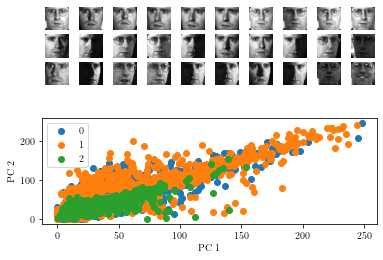

In [18]:
do_gmm(NUM_PIXELS, X_train)


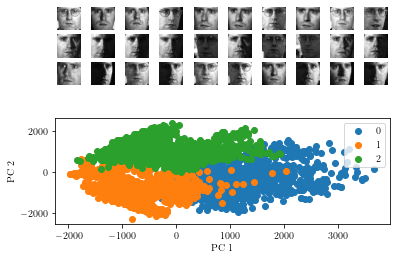

In [19]:
do_gmm(200, X_pca[:, :200])


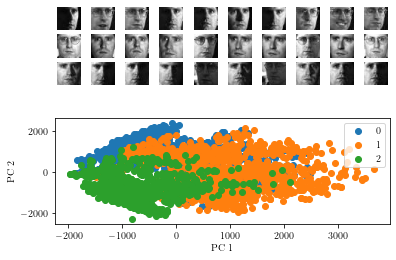

In [20]:
do_gmm(80, X_pca[:, :80])
